In [5]:
import nibabel as nib
BOLD = nib.load('Data/sub-01_task-theoryofmindwithmanualresponse_run-01_bold.nii.gz')
BOLD

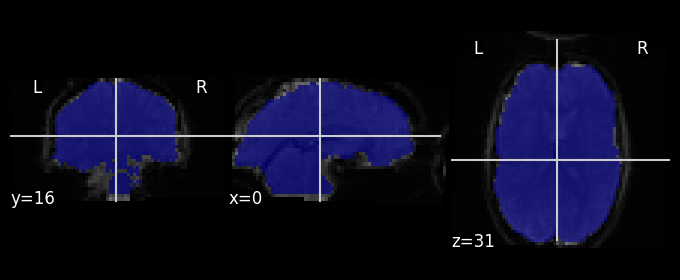

In [6]:
from nilearn.masking import compute_epi_mask
from nilearn.plotting import plot_roi
from nilearn.image.image import mean_img
mean_haxby = mean_img(BOLD)
mask_img = compute_epi_mask(BOLD, connected=False)
plot_roi(mask_img,mean_haxby)

In [7]:
from nilearn.masking import apply_mask
masked_data = apply_mask(BOLD, mask_img)
masked_data.shape

(179, 40078)

In [36]:
np.save('Data/BOLD_Masked.npy',masked_data)

In [111]:
import pandas as pd

df_events1 = pd.read_csv('Data/sub-01_task-theoryofmindwithmanualresponse_run-01_events.tsv',sep='\t')
df_events1

,onset,duration,trial_type,ConditionCode,CorrectAnswerCode,KeyPressed,ResponseTime,StoryCode
0,0.0,2.0,NaN,0.0,0.0,46.0,1.980,0.0
1,2.0,2.0,NaN,0.0,0.0,46.0,1.992,0.0
2,4.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
3,6.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
4,8.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
...,...,...,...,...,...,...,...,...
198,348.0,2.0,NaN,0.0,0.0,46.0,1.985,0.0
199,350.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
200,352.0,2.0,NaN,0.0,0.0,46.0,2.003,0.0
201,354.0,2.0,NaN,0.0,0.0,46.0,1.995,0.0


In [112]:
stim_ev1 = df_events1[df_events1['trial_type'].notnull()]
df_ev1 = df_events1[df_events1['trial_type'].isnull()].reset_index(drop=True)
for r in range(len(stim_ev1)):
  df_ev1.at[int(stim_ev1.iloc[r,0]/2),'duration'] = stim_ev1.iloc[r,:]['duration']
  df_ev1.at[int(stim_ev1.iloc[r,0]/2),'trial_type'] = stim_ev1.iloc[r,:]['trial_type']

df_ev1

,onset,duration,trial_type,ConditionCode,CorrectAnswerCode,KeyPressed,ResponseTime,StoryCode
0,0.0,2.0,NaN,0.0,0.0,46.0,1.980,0.0
1,2.0,2.0,NaN,0.0,0.0,46.0,1.992,0.0
2,4.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
3,6.0,2.0,NaN,0.0,0.0,46.0,1.994,0.0
4,8.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
...,...,...,...,...,...,...,...,...
174,348.0,2.0,NaN,0.0,0.0,46.0,1.985,0.0
175,350.0,2.0,NaN,0.0,0.0,46.0,1.993,0.0
176,352.0,2.0,NaN,0.0,0.0,46.0,2.003,0.0
177,354.0,2.0,NaN,0.0,0.0,46.0,1.995,0.0


In [115]:
df_ev1['trial_type'].unique()
df_ev1['trial_type'].replace(['false belief question','false belief story','false photo question','false photo story'],['stimulus1','stimulus2','stimulus3','stimulus4'],inplace=True)

/opt/homebrew/lib/python3.11/site-packages/nilearn/glm/first_level/experimental_paradigm.py:120: UserWarning: Duplicated events were detected. Amplitudes of these events will be summed. You might want to verify your inputs.
  warnings.warn(


<Axes: label='conditions', ylabel='scan number'>

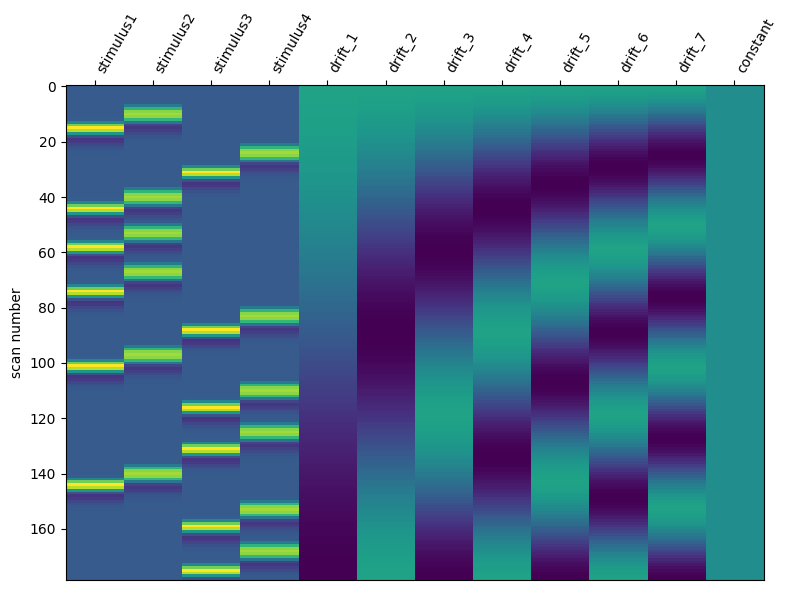

In [116]:
import numpy as np
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt

tr = 2.0  # repetition time is 2 seconds
n_scans = 179  # the acquisition comprises 179 scans
frame_times = np.arange(n_scans) * tr

conditions = df_ev1['trial_type']
duration = df_ev1['duration']
onsets = df_ev1['onset']

events = pd.DataFrame({'trial_type': conditions, 'onset': onsets, 'duration': duration})

X1 = make_first_level_design_matrix(frame_times, events)

fig, ax = plt.subplots(figsize=(8, 6))
plot_design_matrix(X1, ax=ax)

In [32]:
import bayesianModel as bM
pMap = []
for v in range(len(masked_data[0])):
    BOLDv = masked_data[:,v][np.newaxis].T
    b = bM.betas(X1.values,BOLDv)
    pMap.append(sum(b[:,0]>0)/1000)

In [37]:
pMap = np.array(pMap)

In [45]:
pMap = pMap[np.newaxis]
pMap

array([[0.933, 0.965, 0.99 , ..., 0.059, 0.01 , 0.268]])

In [10]:
import numpy as np
#np.save('Data/pMap.npy',pMap)
pMap = np.load('Data/pMap.npy')

In [11]:
from nilearn.masking import unmask
pMap_UM = unmask(pMap[0],mask_img)
pMap_UM

(-0.5, 35.5, 71.5, -0.5)

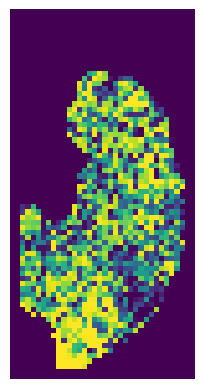

In [13]:
import matplotlib.pyplot as plt
plt.imshow(pMap_UM.get_fdata()[36,:,:])
plt.axis('off')

In [8]:
from nilearn.image import new_img_like
NIFTI = new_img_like(pMap_UM, pMap_UM.get_fdata())

In [9]:
NIFTI

In [10]:
from nilearn.masking import apply_mask
apply_mask(NIFTI,mask_img)

array([0.933, 0.965, 0.99 , ..., 0.059, 0.01 , 0.268])

In [11]:
import th_sm as thSM
Z,N,e,X = thSM.th_sm(pMap[0],mask_img)

Termination by Jaccard Index in  6  iterations.


In [2]:
import numpy as np
#np.save('Data/Zeta.npy',Z)
#np.save('Data/N.npy',N)
#np.save('Data/eta.npy',e)
#np.save('Data/X.npy',X)

Z = np.load('Data/Zeta.npy')
N = np.load('Data/N.npy')
e = np.load('Data/eta.npy')
X = np.load('Data/X.npy')

In [15]:
import matplotlib
def plot(IMG1,IMG2,i,x=-1,y=-1,z=-1):
    UM1 = unmask(IMG1[i],mask_img)
    UM2 = unmask(IMG2[i],mask_img)
    if x*y == 1:
        cmap1 = matplotlib.colors.ListedColormap(['none', 'yellow'])
        #im1 = plt.imshow(UM2.get_fdata()[:,:,z], cmap=cmap1)
        #im2 = plt.imshow(UM1.get_fdata()[:,:,z], cmap='gray')
        im2 = plt.imshow(UM1.get_fdata()[:,:,z])
        plt.axis('off')
        plt.show()
    elif y*z == 1:
        cmap1 = matplotlib.colors.ListedColormap(['none', 'yellow'])
        plt.imshow(UM1.get_fdata()[x,:,:], cmap=cmap1)
        plt.axis('off')
    elif x*z == 1:
        plt.imshow(UM1.get_fdata()[:,y,:])
        plt.axis('off')
    else:
        pass

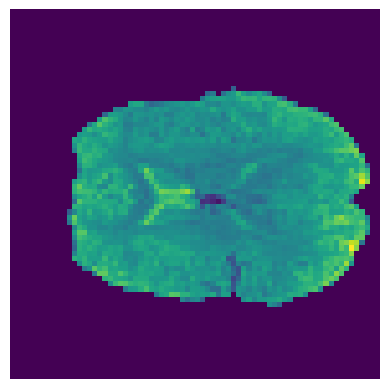

In [17]:
plot(masked_data,Z,0,z=18)

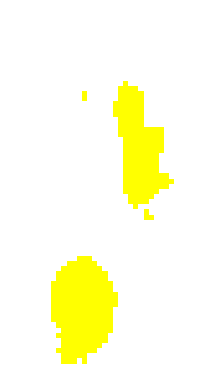

In [98]:
plot(Z,6,x=36)

In [48]:
sum(Z[6])/len(Z[6])

0.13361445181895304